Option

In [ ]:
!pip install imbalanced-learn
!pip install pandas scikit-learn

Import necessary libraries

In [1]:
import pandas as pd
import zipfile
import requests
from io import BytesIO
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Loading Supervised Datasets from GitHub Repository

In [2]:
import zipfile
import requests
from io import BytesIO

# Define the base URL of the repository and dataset file names
base_url = "https://github.com/orifelszer/CrimeData/raw/main/"
files = {
    "X_train": "X_train_supervised.zip",
    "X_test": "X_test_supervised.zip",
    "y_train": "y_train_supervised.zip",
    "y_test": "y_test_supervised.zip"}

# Function to download and extract ZIP files from the GitHub repository
def load_data_from_repo(file_name):
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            extracted_file_name = z.namelist()[0]
            with z.open(extracted_file_name) as f:
                return pd.read_csv(f)
    else:
        raise Exception(f"Failed to download {file_name}")

# Load datasets from the repository
X_train = pd.DataFrame(load_data_from_repo(files["X_train"]))
X_test = pd.DataFrame(load_data_from_repo(files["X_test"]))
y_train = pd.DataFrame(load_data_from_repo(files["y_train"]))
y_test = pd.DataFrame(load_data_from_repo(files["y_test"]))

Handling Imbalanced Data Using SMOTE and Sampling for Faster Training

In [ ]:
# Apply SMOTE for balancing the dataset by oversampling the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Use a smaller subset of the balanced training data (30%) to reduce training time
X_train_sample = X_train_balanced.sample(frac=0.3, random_state=42)
y_train_sample = y_train_balanced[X_train_sample.index]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Defining the Random Forest Classifier with Optimized Parameters

In [ ]:
# Initialize the Random Forest classifier with hyperparameter optimization
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42)

Training and Evaluating the Random Forest Classifier

In [ ]:
# Train the Random Forest model using the sampled training data
rf_model.fit(X_train_sample, y_train_sample)

# Generate predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's accuracy and generate a classification report
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation results
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report:\n", classification_report_rf)

Accuracy: 4.80%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.09      0.00       366
           1       0.09      0.14      0.11      7408
           2       0.01      0.17      0.03      3288
           3       0.08      0.04      0.05     23317
           4       0.39      0.04      0.08    126443
           5       0.05      0.15      0.08      6912
           6       0.00      0.08      0.00       126
           7       0.05      0.03      0.04     17566
           8       0.00      0.21      0.00       625
           9       0.18      0.02      0.04     59252
          10       0.38      0.05      0.09    128157
          11       0.00      0.19      0.01      1377
          12       0.01      0.21      0.01      2074
          13       0.00      0.07      0.00        60

    accuracy                           0.05    376971
   macro avg       0.09      0.11      0.04    376971
weighted avg       0.30      0.05      0

The overall accuracy of the model is 4.80%, which indicates that the model correctly predicted the crime categories for only 4.8% of the test samples. This low accuracy suggests significant challenges in distinguishing between the different classes in the dataset.

Plotting the Confusion Matrix for the Random Forest Model

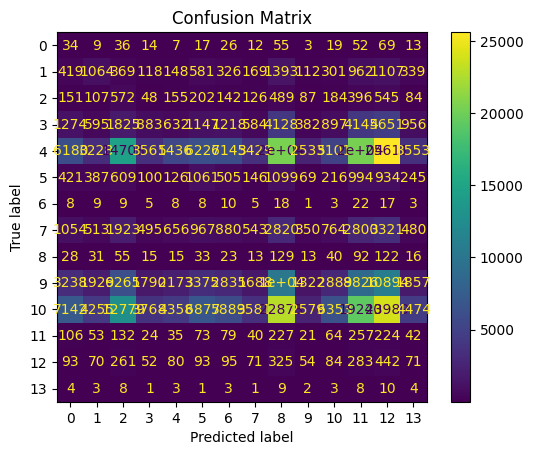

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# Generate and plot the confusion matrix using the trained model and test data
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='viridis')

# Add a title for clarity
plt.title("Confusion Matrix")
plt.show()

While the model has some success (higher values on the diagonal), the spread of off-diagonal values suggests challenges with distinguishing between certain classes.

Feature Importance Analysis for the Random Forest Model

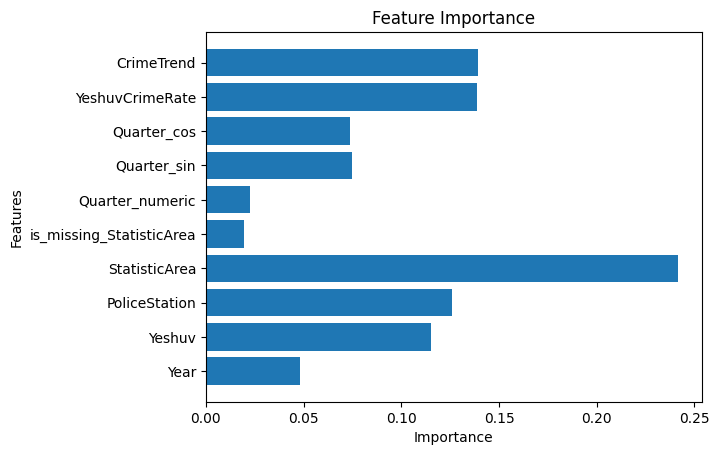

In [ ]:
# Extract feature importances from the trained model
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Create a horizontal bar plot to visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

This bar chart displays the importance of each feature in making predictions using the Random Forest model. The most influential feature is StatisticArea, contributing significantly to the model's predictions. PoliceStation and YeshuvCrimeRate also highly important, but to a lesser degree